# ML Training workflows for WMF researchers

Experiments in implementing useful abstractions to enable researchers to do model training in jupyter notebooks,  using WMF's compute and data infrastructure. 

## Setup

Two common use-cases are:

- Using research-datasets. Exploratory research projects done in a stand-alone notebook, which uses the research-datasets repo as a dependency but there is no need to change code in research-datasets itself. The notebook can import methods to retrieve ML features, train models, etc.
- Updating research-datasets: a project where a notebook is used for interactive development, which depends on changes in the research-datasets repo. Examples:
    - the code complexity requires more structure than a notebook, so the code is added to research-datasets. 
    - functionality useful for other notebooks, so the code is added to research-datasets to make it available
    - a project beyond the exploratory phase, and the goal is to implement workflows that can run in production.

### Using research-datasets

In stand-alone notebooks, the dependencies are installed via pip install. 

In [ ]:
# research pipelines
!pip install git+https://gitlab.wikimedia.org/repos/research/research-datasets.git


### Updating research-datasets

Clone the repo (`git clone https://gitlab.wikimedia.org/repos/research/research-datasets.git`) on the stat client of your choice.

#### Jupyter notebooks

Navigate to juptyer hub on the client machine, and open this notebook from the `notebook` folder in  cloned repo.



In [ ]:
# install research-datasets python project located in the parent as editable
!pip install --editable ..


#### VS code

Using the interactive python and juptyer notebook support in VS code is convenient especially if you wanto to make changes to the research-datasets package. 
- install the VS code extensions for python, juptyer, and remote SSH development
- open a remote ssh connection with the stat client, and open the research-datasets folder
- open this notebook
- click on "select kernel -> select another kernel -> python environments -> create python environment -> venv". This will create a python environment in the `.venv` with the research-datasets package installed

#### Autoreload

Enabling autoreload, any changes to the cloned research-datasets repo will  be picked up in the notebook without restarting the kernel.

In [1]:

%load_ext autoreload
%autoreload 2


## Spark context

The spark context used to submit job to the yarn cluster needs to ensure that the research-datasets package (and other dependencies) are available in the spark workers. The [research-common](https://gitlab.wikimedia.org/repos/research/research-common.git) can create a spark context configured to use a conda environment packaged by gitlab CI.

In [ ]:
!pip install git+https://gitlab.wikimedia.org/repos/research/research-common.git

In [ ]:
from research_common.spark import create_yarn_spark_session

conf = {
    "spark.dynamicAllocation.maxExecutors": 99,
    "spark.executor.cores": 4,
    "spark.sql.shuffle.partitions": 2000,
    "spark.executor.memory": "16g",
    "spark.executor.memoryOverhead": "2g",
}
spark = create_yarn_spark_session(
    app_id="revert_risk_training",
    extra_config=conf,
    gitlab_project="repos/research/research-datasets")


## Example: train XGBoost classifier

This example trains a xgboost classifier for the revert risk model end-to-end. `research-datasets` is used as a library, and no code is changed in the repo. 
- create a features dataset
- train a xgboost classifier using pyspark ML
- run batch prediction on the model for a test dataset
- evaluate metrics and compare the trained model to the production model

## Features dataset

Create a features dataset for the revert risk model - for training and for testing. We can use an existing pipeline in research-datasets, for new projects the code can be implemented either in the notebook, or in the repo directly.

In [4]:
from datetime import datetime
from pathlib import Path
from research_datasets.revert_risk import features
from research_datasets.time import Period

snapshot = "2024-02"
wiki_dbs = ["simplewiki"]
start_time = datetime.strptime("2024-01-01", "%Y-%m-%d")
end_time = datetime.strptime("2024-02-01", "%Y-%m-%d")


In [5]:
feature_df = features.generate_feature_set(
    spark=spark,
    snapshot=snapshot,
    wiki_dbs=wiki_dbs,
    period=Period(start_time, end_time),
    featurizer=features.LanguageAgnosticFeaturizer,
    drop_disputed_reverts=True,
    drop_anonymous_edits=False,
    max_rows_per_wiki=None,
)


In [12]:
train_df, test_f = feature_df.randomSplit([0.7,0.3])

train_df.write.parquet("revert_risk/train", mode="overwrite")
test_f.write.parquet("revert_risk/test", mode="overwrite")

feature_df.show(5,truncate=False)

+-------+----------+-------+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rev_id |wiki_db   |page_id|rev_is_identity_reverted|features                                                                                                                                                                              

### Train XGBoost model

Train a distributed xgboost classifier using pyspark ML.

The pyspark integration for xgboost doesn't support a dynamic allocation of worker instances, which is otherwise the preferred/recommended way to configure spark. For training a model, we need to create a spark context with a fixed number of instances. 

In [ ]:
from research_common.spark import create_yarn_spark_session

num_workers = 20

conf = {
    "spark.dynamicAllocation.enabled": False,
    "spark.executor.instances": num_workers,
    "spark.executor.cores": 2,
    "spark.executor.memory": "16g",
    "spark.executor.memoryOverhead": "2g",
}
spark = create_yarn_spark_session(
    app_id="xgboosting",
    extra_config=conf,
    gitlab_project="repos/research/research-datasets")

In [2]:
# read the training features dataset
train_df = spark.read.parquet("revert_risk/train").cache()

24/04/25 02:17:26 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


To train the revert risk model, we could use the code from revert_risk pipeline directly.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

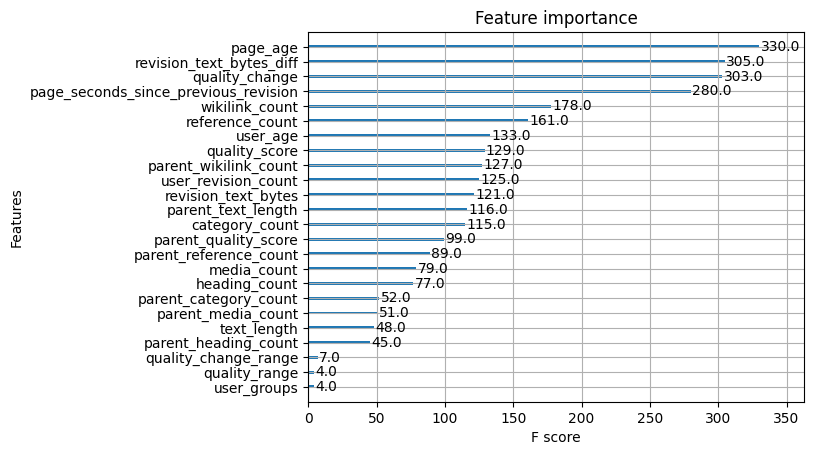

In [4]:
from research_datasets.revert_risk import train
from xgboost import plot_importance

revert_risk_model = train.train_language_agnostic_model(train_df, num_workers=num_workers-2, balance_labels=True)

plot_importance(revert_risk_model.classifier)

An example using a parameter grid search and cross validation:

In [ ]:
# !pip install matplotlib
from research_datasets.revert_risk import features, train

# define a grid of xgboost parameters to search
grid_params = [
    ("max_depth", [2, 5]),
    ("n_estimators", [10, 100]),
]

# train the model using pyspark ml
trainer = train.train_model_param_grid(
    binary_label_col="rev_is_identity_reverted",
    num_workers=num_workers,
    grid_params=grid_params,
    feature_names=features.LanguageAgnosticFeaturizer.feature_names
)
spark_xgb_model = trainer(train_df)

spark_xgb_model.write().overwrite().save("revert_risk/model")

### Batch prediction

The trained model can be used to run inference at scale. In this notebook we batch predict the revert risk probability on the test dataset. 

Note that dynamic allocation of spark workers is supported when running inference on xgboost models, as opposed to model training which requires a fixed set of executors.


In [6]:
from research_datasets.revert_risk import predict

test_df = spark.read.parquet("revert_risk/test").cache()

predictor = predict.predict_revert_risk(revert_risk_model)
pred_df = test_df.transform(predictor)
pred_df.show()

+-------+----------+-------+------------------------+---------------+
| rev_id|   wiki_db|page_id|rev_is_identity_reverted|rev_revert_risk|
+-------+----------+-------+------------------------+---------------+
|9284148|simplewiki| 892117|                   false|    0.011993019|
|9295552|simplewiki| 305725|                   false|   0.0045847343|
|9282151|simplewiki| 219587|                    true|      0.9177409|
|9290126|simplewiki| 863673|                   false|    0.058667477|
|9287243|simplewiki|1050065|                   false|   0.0034608769|
|9332560|simplewiki|  98583|                   false|      0.9568743|
|9294679|simplewiki|  78518|                   false|     0.96179336|
|9284583|simplewiki|  16213|                   false|    8.162133E-4|
|9291516|simplewiki| 474128|                   false|    3.676232E-4|
|9287231|simplewiki|1048688|                   false|   1.5750654E-4|
|9282040|simplewiki| 674635|                   false|    4.526057E-4|
|9288567|simplewiki|

### Evaluation metrics

The revert risk model is a binary classifier, returning a revert risk prediction between 0 and 1. A production system using this model needs to define a prediction probability threshold for when to take action. For example, a threshold of 0.5 will likely lead to more false positives than a threshold of 0.9, while the latter will lead to more false negatives. 

For the prediction on the test dataset, we calculate a set of evaluation metrics (precision, recall, accuracy, fpr, F1) to inspect the quality of the model, for a set of possible thresholds.

In [7]:
from research_datasets.revert_risk import evaluate

# evaluation metrics by wiki_db
evaluator = evaluate.evaluation_metrics(
    grouping_cols=["wiki_db"]
)

eval_df = pred_df.transform(evaluator).cache()

eval_df.show()

+----------+---------+-------------------+------------------+-------------------+-------------------+-------------------+
|   wiki_db|threshold|          precision|            recall|           accuracy|                fpr|                 F1|
+----------+---------+-------------------+------------------+-------------------+-------------------+-------------------+
|simplewiki|        0|0.10657514450867052|               1.0|0.10657514450867052|                1.0|0.19262161279791057|
|simplewiki|        1|   0.16136739569932| 0.992090395480226| 0.4496628131021195| 0.6150424585523655| 0.2775845716092317|
|simplewiki|        2|0.17692463944749137| 0.984180790960452| 0.5103564547206165| 0.5461652513815878|0.29993112947658407|
|simplewiki|        3|0.18698659749243407|0.9774011299435028| 0.5446772639691715| 0.5069416363391293|0.31391761930684087|
|simplewiki|        4| 0.1939189189189189|0.9728813559322034| 0.5661127167630058|0.48241002830570157| 0.3233802816901408|
|simplewiki|        5|0.

Plot the ROC and compute the AUC as example analysis.

wiki_db
simplewiki    0.86483
dtype: float64

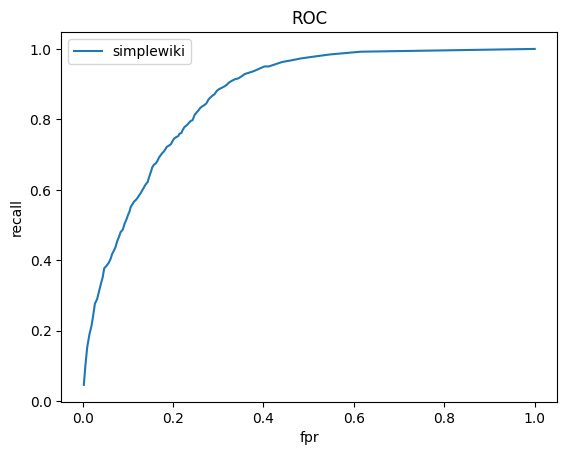

24/04/25 02:31:13 WARN UserGroupInformation: Not attempting to re-login since the last re-login was attempted less than 60 seconds before. Last Login=1714012244614
24/04/25 02:31:44 WARN UserGroupInformation: Exception encountered while running the renewal command for fab@WIKIMEDIA. (TGT end time:1714012281000, renewalFailures: 0,renewalFailuresTotal: 1)
ExitCodeException exitCode=1: kinit: Ticket expired while renewing credentials

	at org.apache.hadoop.util.Shell.runCommand(Shell.java:1008)
	at org.apache.hadoop.util.Shell.run(Shell.java:901)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1213)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1307)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1289)
	at org.apache.hadoop.security.UserGroupInformation$AutoRenewalForUserCredsRunnable.run(UserGroupInformation.java:900)
	at java.lang.Thread.run(Thread.java:750)
24/04/25 02:31:44 ERROR UserGroupInformation: TGT is expired. Aborting renew thread f

In [8]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from sklearn.metrics import auc

# w = ["enwiki", "frwiki", "dewiki", "arwiki", "eswiki", "simplewiki"]
w = ["simplewiki"]
p = eval_df.where(F.col("wiki_db").isin(w)).toPandas()
ax = plt.gca()
for l, df in p.groupby("wiki_db"):
    df.plot("fpr", "recall", label=l, ax=ax, ylabel="recall", title="ROC")

auc_df = p.groupby("wiki_db").apply(lambda df: auc(df.fpr, df.recall))
auc_df
